In [1]:
!pip install openpyxl

In [2]:
!unzip /content/drive/MyDrive/Dataset.zip -d /content/Dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9042.jpg  
  inflating: /content/Dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9043.jpg  
  inflating: /content/Dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9044.jpg  
  inflating: /content/Dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9045.jpg  
  inflating: /content/Dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9046.jpg  
  inflating: /content/Dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9047.jpg  
  inflating: /content/Dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9049.jpg  
  inflating: /content/Dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9052.jpg  
  inflating: /content/Dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9054.jpg  
  inflating: /content/Dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9057.jpg  
  inflating: /content/Dataset/Dataset/v

In [3]:
training_dir = "/content/Dataset/Dataset/training"
validation_dir ="/content/Dataset/Dataset/validation"

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Attention, Activation
from keras.layers import Dropout, BatchNormalization, Multiply
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils import class_weight
from keras.applications import Xception
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
import xgboost as xgb
from sklearn.metrics import accuracy_score
import os

In [5]:
!pip install xgboost

In [6]:
def load_and_preprocess_image(base_dir, path, target_size):
    img_path = os.path.join(base_dir, path.replace('\\', '/'))
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    preprocessed_img = preprocess_input(img_array)
    return preprocessed_img

def get_data_for_training(excel_path, base_dir, image_size=(32, 32)):
    df = pd.read_excel(excel_path)
    df = df.dropna(subset=['image_path'])
    class_names = df.columns[2:]
    X = np.array([load_and_preprocess_image(base_dir, path, image_size) for path in df['image_path'].values])
    y = df[class_names].values
    return X, y, df['image_path'].values

In [7]:
if __name__ == "__main__":
    train_excel_path = "/content/Dataset/Dataset/training/training_data.xlsx"
    val_excel_path = "/content/Dataset/Dataset/validation/validation_data.xlsx"
    base_dir = "/content/Dataset/Dataset"
    image_size = (32, 32)
    batch_size = 4096
    epochs = 10

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Load full training and validation data
X_train_full, y_train_full, _ = get_data_for_training(train_excel_path, base_dir, image_size=image_size)
print("Full train data loaded")
X_val_full, y_val_full, image_paths = get_data_for_training(val_excel_path, base_dir, image_size=image_size)
print("Full val data loaded")

train_sample_size = int(len(X_train_full))
val_sample_size = int(len(X_val_full))

# Calculate class weights based on the sampled training data
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
y_train_labels = np.argmax(y_train_full, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

Full train data loaded
Full val data loaded


In [29]:
# Create an ImageDataGenerator for loading and resizing images
datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalize pixel values to [0, 1]

# Load training data with resizing
train_generator = datagen.flow_from_directory(
    training_dir,
    target_size=(75, 75),  # Resize images to 75x75
    batch_size=32,
    class_mode='sparse'  # Use 'sparse' for sparse categorical labels
)

# Load validation data with resizing
val_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(75, 75),  # Resize images to 75x75
    batch_size=32,
    class_mode='sparse'  # Use 'sparse' for sparse categorical labels
)

# Define the model creation function
def create_inceptionv3_model(input_shape, num_classes):
    # Load InceptionV3 as the base model
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    # Create custom layers on top of InceptionV3
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Set input shape to (75, 75, 3)
input_shape = (75, 75, 3)
num_classes = train_generator.num_classes  # Automatically set to the number of classes

# Create and compile the InceptionV3 model
inceptionv3_model = create_inceptionv3_model(input_shape, num_classes)

# Compile the model
inceptionv3_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generators
history = inceptionv3_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

# Evaluate the model
loss, accuracy = inceptionv3_model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Found 37607 images belonging to 10 classes.
Found 16132 images belonging to 10 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 101s 57ms/step - accuracy: 0.7543 - loss: 0.9991 - val_accuracy: 0.7787 - val_loss: 0.7163
Epoch 2/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.7784 - loss: 0.7409 - val_accuracy: 0.7827 - val_loss: 0.6759
Epoch 3/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.7865 - loss: 0.6928 - val_accuracy: 0.7949 - val_loss: 0.6491
Epoch 4/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.7863 - loss: 0.6768 - val_accuracy: 0.7977 - val_loss: 0.6407
Epoch 5/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 75s 41ms/step - accuracy: 0.7931 - loss: 0.6464 - val_accuracy: 0.7971 - val_loss: 0.6297
Epoch 6/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - accuracy: 0.8015 - loss: 0.6143 - val_accuracy: 0.7970 - val_loss: 0.6530
Epoch 7/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - accuracy: 0.8014 - loss: 0.6142 - val_accuracy: 0.8057 - val_loss: 0.6144
Epoch 8/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.8016 - loss: 0.6

In [31]:
# Create feature extractor model
feature_extractor = Model(inputs=inceptionv3_model.input, outputs=inceptionv3_model.layers[-3].output)

# Extract features using the feature extractor on the validation generator
train_features = feature_extractor.predict(train_generator, steps=train_generator.samples // train_generator.batch_size)
val_features = feature_extractor.predict(val_generator, steps=val_generator.samples // val_generator.batch_size)


1175/1175 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step


505/505 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.6696 - loss: 1.0929
Validation Loss: 0.6243
Validation Accuracy: 0.8124
505/505 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step
Confusion Matrix:
[[3.70221328e-01 4.02414487e-03 1.28772636e-01 0.00000000e+00
  0.00000000e+00 2.01207243e-03 4.92957746e-01 2.01207243e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.53760446e-01 1.53203343e-01 2.78551532e-03
  0.00000000e+00 0.00000000e+00 4.87465181e-01 2.78551532e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.19480519e-03 3.49783550e-01 1.73160173e-03
  1.73160173e-03 3.46320346e-03 6.33766234e-01 8.65800866e-04
  3.46320346e-03 0.00000000e+00]
 [0.00000000e+00 6.73400673e-03 2.82828283e-01 3.70370370e-02
  3.36700337e-03 0.00000000e+00 6.59932660e-01 1.01010101e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.88235294e-03 7.35294118e-02 2.94117647e-03
  4.14705882e-01 5.88235294e-03 4.88235294e-01 5.88235294e-03
  2.94117647e-03 0.00000000e+00]
 [0.00000000e+00 8.746355

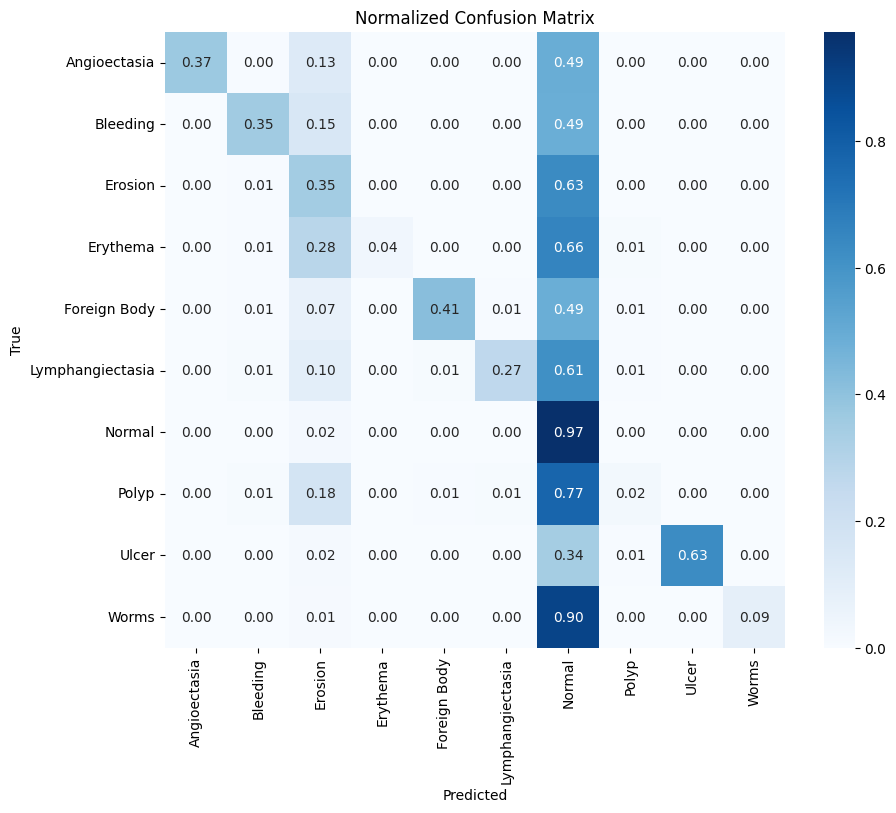

505/505 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step


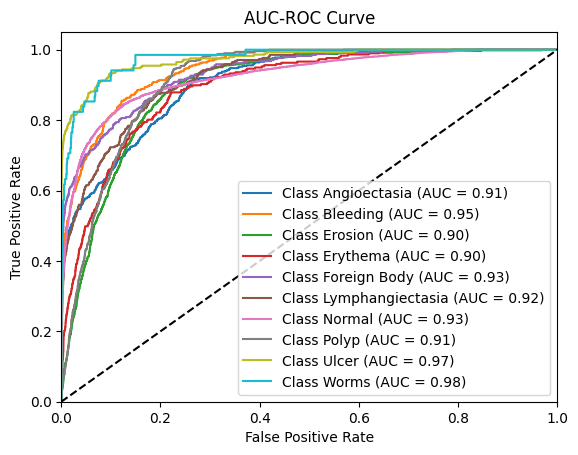

In [43]:
loss, accuracy = inceptionv3_model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Get true labels for validation set
y_val_classes = val_generator.classes  # True class labels
y_pred_classes = np.argmax(inceptionv3_model.predict(val_generator), axis=1)  # Predicted class labels

# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_val_classes, y_pred_classes, normalize='true')
print(cm)

# Print the classification report
print("Classification Report:")
print(classification_report(y_val_classes, y_pred_classes))

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Plot AUC-ROC curve for each class
lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val_classes)  # Binarize the true labels
y_pred_proba = inceptionv3_model.predict(val_generator)  # Get predicted probabilities

# Check dimensions of y_pred_proba
if y_pred_proba.ndim == 1:  # This means it's likely only one class was predicted
    y_pred_proba = y_pred_proba.reshape(-1, 1)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert class names to a list for indexing
class_names = list(train_generator.class_indices.keys())

plt.figure()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_val_bin[:, i], y_pred_proba[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [44]:
# Calculate and print the mean AUC of all classes
mean_auc = np.mean(list(roc_auc.values()))
print(f'Mean AUC of all classes: {mean_auc:.2f}')

Mean AUC of all classes: 0.93
